In [1]:
import re
import numpy as np
import pandas as pd
from math import * 
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline 

In [2]:
#for i in range(len(prices)):
    #prices[i] = prices[i].replace(',', '')
    #prices[i] = prices[i].strip('$')
    #prices[i] = float(prices[i])
   

## Calendar Data 

In [46]:
time_data = pd.read_csv('Airbnb_data/calendar.csv', delimiter=',')
time_data.drop(columns=['maximum_nights'], inplace=True)
time_data.drop(columns=['minimum_nights'], inplace=True)
time_data.head()
from sklearn.utils import shuffle
time_data=shuffle(time_data, random_state=0)

In [47]:
# Regex the price and generate log(price)
time_data['price'] = time_data['price'].replace('[\$,)]','', regex=True).replace('[(]','-', regex=True).astype(float)
time_data['log_price'] = np.log(time_data['price'].values)

In [48]:
time_data = time_data[np.isfinite(time_data['price'])]
#time_data.dropna(thresh=4)
time_data.drop(columns=['available'], inplace=True)

In [49]:
time_data.size

62822905

In [50]:
# Only consider data for which there is data
nan_adjusted = time_data[np.isfinite(time_data['log_price'])]

In [51]:
#Still left with a reasonable amount of observations
grouped = nan_adjusted.groupby(['listing_id'], as_index = False)

means = grouped['price'].mean().values


In [52]:
# Group by listing_id, then find each listing id's average price
grouped = nan_adjusted.groupby(['listing_id'], as_index = False)

means = grouped['price'].mean().values
log_means = grouped['log_price'].mean().values

In [53]:
# log_means = grouped['log_price'].mean().values
# plt.hist(means, bins='auto')  # arguments are passed to np.histogram
# plt.title("distribution of mean price by listing_id")
# plt.show()

# plt.hist(time_data['price'], bins='auto')  # arguments are passed to np.histogram
# plt.title("distribution of mean price by listing_id")
# plt.show()

# plt.hist(log_means, bins='auto')  # arguments are passed to np.histogram
# plt.title("distribution of the mean of log(price) by listing_id")
# plt.show()

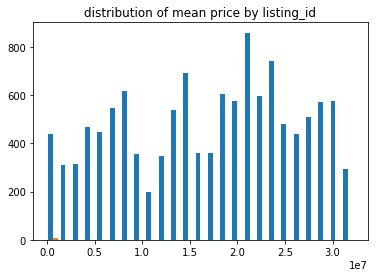

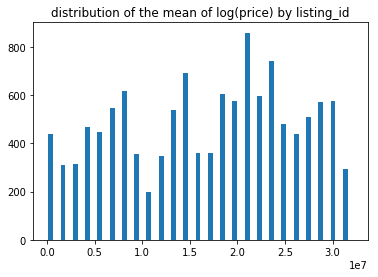

In [54]:

means = grouped['price'].mean().values
log_means = grouped['log_price'].mean().values
plt.hist(means, bins='auto')  # arguments are passed to np.histogram
plt.title("distribution of mean price by listing_id")
plt.show()

plt.hist(log_means, bins='auto')  # arguments are passed to np.histogram
plt.title("distribution of the mean of log(price) by listing_id")
plt.show()

In [55]:
#Goals: 
# 1)Get the average price for each specific listing [done]
# 2)Compute the distance between each day's price and the average price [done]
# 3)Visualize spikes [done]
# 4)For each day, check the change in price [done]

In [56]:
# Find high demand dates by checking for positive distance between a listings average price and it's current price.
# For these purposes, high demand is categorized as a date which experienced, on average, properties being 
# priced above their average list price

In [57]:
print ("number of unique properties:", len(nan_adjusted['listing_id'].unique()))

number of unique properties: 12262


In [58]:
# Let's sort to make things easier on pattern matching algorithm
#df.sort_values(by='col1', ascending=False)
#nan_adjusted.sort_values(by=['listing_id'], inplace=True)
#time_data.sort_values(by=['listing_id'], inplace=True)

In [59]:
mean_df = grouped.mean()
#mean_df['listing_id']

In [60]:
# Maybe I need to reset the index, who the hell knows if I'll use this later
#nan_adjusted.reset_index(inplace=True)


In [61]:
time_data['price_diff'] = 0
time_data.head()

,adjusted_price,date,listing_id,price,log_price,price_diff
8931704,NaN,2019-10-29,21253564,36.0,3.583519,0
578301,NaN,2019-02-13,10542140,350.0,5.857933,0
14445766,$64.00,2019-10-08,31101954,64.0,4.158883,0
6885269,NaN,2018-07-02,21796886,674.0,6.513230,0
18805783,NaN,2018-08-27,26122149,560.0,6.327937,0


In [62]:
# Initialize an empty column for the price differences 
nan_adjusted['price_diff'] = 0


In [77]:
nan_adjusted['listing_id'].count()/1000
nan_adjusted.drop(columns=['level_0'], inplace=True)
nan_adjusted.drop(columns=['index'], inplace=True)
nan_adjusted.reset_index(inplace=True)

nan_adjusted

,index,adjusted_price,date,listing_id,price,log_price,price_diff
0,0,NaN,2019-10-29,21253564,36.0,3.583519,0
1,1,NaN,2019-02-13,10542140,350.0,5.857933,0
2,2,$64.00,2019-10-08,31101954,64.0,4.158883,0
3,3,NaN,2018-07-02,21796886,674.0,6.513230,0
4,4,NaN,2018-08-27,26122149,560.0,6.327937,0
5,5,NaN,2019-06-22,24649966,434.0,6.073045,0
6,6,$228.00,2019-07-20,21026534,228.0,5.429346,0
7,7,NaN,2019-02-12,29648289,59.0,4.077537,0
8,8,$103.00,2019-08-04,30856009,103.0,4.634729,0
9,9,$214.00,2019-11-05,30503876,214.0,5.365976,0


In [139]:
# i=

# nan_adjusted.iloc[i]['price_diff'] = nan_adjusted.iloc[i]['price'] - mean_df.iloc[nan_adjusted.iloc[i]['listing_id']]['price']
# print(nan_adjusted.iloc[i]['price_diff']) 



In [22]:
# for i in range(0,729):
#     nan_adjusted.iloc[i]['price_diff'] = nan_adjusted.iloc[i]['price'] - mean_df.iloc[nan_adjusted.iloc[i]['listing_id']]['price']
    
    

In [80]:
# Subset dataframe of averages for left-merge
mean_df_new = mean_df[['listing_id','price']]
mean_df_new.head()

,listing_id,price
0,3353,43.536842
1,3781,135.652268
2,5453,150.000000
3,5506,145.820660
4,6695,173.765442


In [81]:
# Left-Merge
new = nan_adjusted.merge(mean_df_new,how='left', left_on='listing_id', right_on='listing_id')
new.head()

,index,adjusted_price,date,listing_id,price_x,log_price,price_diff,price_y
0,0,NaN,2019-10-29,21253564,36.0,3.583519,0,36.000000
1,1,NaN,2019-02-13,10542140,350.0,5.857933,0,341.440802
2,2,$64.00,2019-10-08,31101954,64.0,4.158883,0,59.719178
3,3,NaN,2018-07-02,21796886,674.0,6.513230,0,441.496583
4,4,NaN,2018-08-27,26122149,560.0,6.327937,0,524.989544


In [82]:
# Compute price differences 
new['price_diff'] = new['price_x'] - new['price_y']
new.head()

,index,adjusted_price,date,listing_id,price_x,log_price,price_diff,price_y
0,0,NaN,2019-10-29,21253564,36.0,3.583519,0.000000,36.000000
1,1,NaN,2019-02-13,10542140,350.0,5.857933,8.559198,341.440802
2,2,$64.00,2019-10-08,31101954,64.0,4.158883,4.280822,59.719178
3,3,NaN,2018-07-02,21796886,674.0,6.513230,232.503417,441.496583
4,4,NaN,2018-08-27,26122149,560.0,6.327937,35.010456,524.989544


In [83]:
# Convert dates to datetime
final = new.groupby(['date'], as_index = False)

dates = pd.to_datetime(new['date'].values)


In [84]:
# Add new datetime object
new['datetime'] = dates


In [85]:
# Groupby datetime, get average price difference
final = new.groupby(['datetime'], as_index = False)
final_sums = final['price_diff'].mean()
final_sums['price_x'] = new['price_x']
final_sums['price_y'] = new['price_x']

final_sums.head()

,datetime,price_diff,price_x,price_y
0,2015-10-02,7.371864,36.0,36.0
1,2015-10-03,16.953006,350.0,350.0
2,2015-10-04,3.833924,64.0,64.0
3,2015-10-05,-0.415049,674.0,674.0
4,2015-10-06,0.293709,560.0,560.0


Text(0.5, 1.0, 'Days When List Price Exceeded Average List Price for Individual AirBnbs')

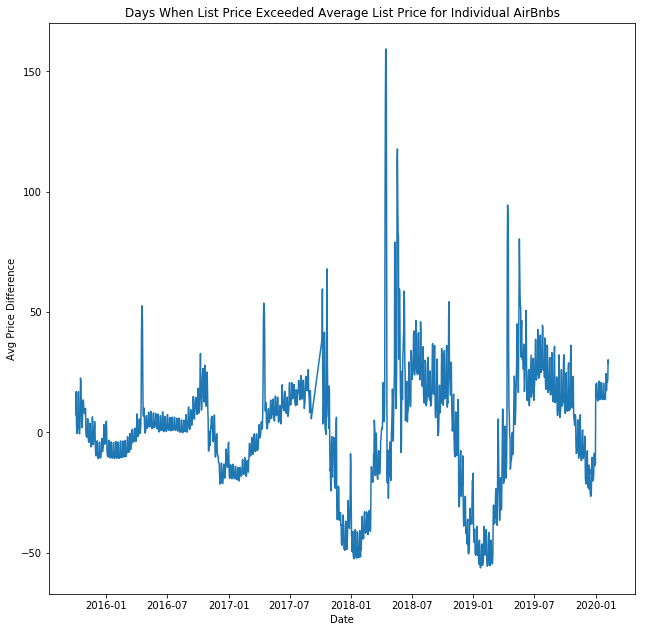

In [86]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# Examine overall price difference trend
final_sums['month_year'] = final_sums['datetime'].dt.to_period('12M')
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5, forward=True)

ax.plot(final_sums['datetime'],final_sums['price_diff'])
# ax.set_xticklabels(final_sums['month_year'] )
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Days When List Price Exceeded Average List Price for Individual AirBnbs')


In [87]:
# Subset the data for easier viewing 
final_sums['month_year'] = final_sums['datetime'].dt.to_period('12M')

fall = final_sums[((final_sums['month_year'] >= '2018-09') & (final_sums['month_year'] <= '2018-12'))] 
winter = final_sums[((final_sums['month_year'] >= '2018-12') | (final_sums['month_year'] <= '2018-03') & (final_sums['month_year'] >='2018-01') & (final_sums['month_year'] <='2019-01'))] 
spring = final_sums[((final_sums['month_year'] >= '2018-03') & (final_sums['month_year'] <= '2018-06'))] 
summer = final_sums[((final_sums['month_year'] >= '2018-06') & (final_sums['month_year'] <= '2018-09'))] 

/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<PeriodArray>
['2018-09', '2018-10', '2018-11', '2018-12']
Length: 4, dtype: period[12M]

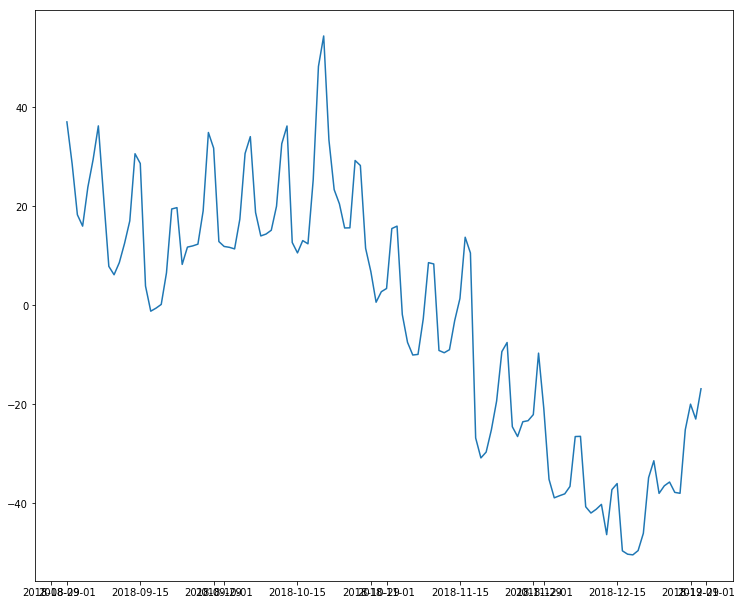

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 10.5, forward=True)
fall['month_year'] = fall['datetime'].dt.to_period('12M')

ax.plot(fall['datetime'],fall['price_diff'])
#ax.set_xticklabels(fall['datetime'].dt.to_period('2M'))

fall['month_year'].unique()

/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


<PeriodArray>
['2018-01', '2018-02', '2018-03', '2018-12', '2019-01', '2019-02', '2019-03',
 '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10',
 '2019-11', '2019-12', '2020-01', '2020-02']
Length: 18, dtype: period[12M]

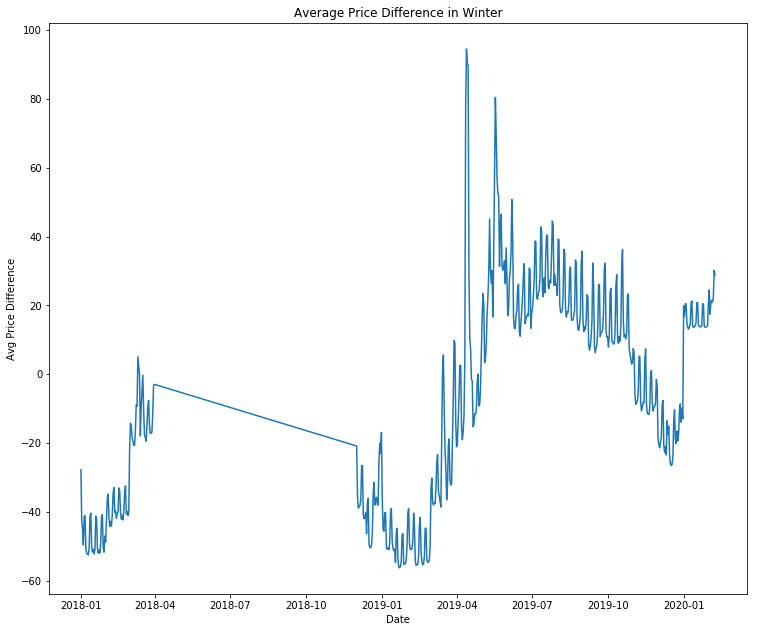

In [89]:
# WINTER 
# fig, ax = plt.subplots()
# fig.set_size_inches(12.5, 10.5, forward=True)
# fall['month_year'] = fall['datetime'].dt.to_period('12M')

# ax.plot(fall['datetime'],fall['price_diff'])
# ax.set_xticklabels(fall['month_year'])

# fall['month_year'].unique()

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 10.5, forward=True)
winter['month_year'] = winter['datetime'].dt.to_period('12M')


ax.plot(winter['datetime'],winter['price_diff'])

# ax.set_xticklabels(winter['month_year'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Winter')
winter['month_year'].unique()

/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<PeriodArray>
['2018-06', '2018-07', '2018-08', '2018-09']
Length: 4, dtype: period[12M]

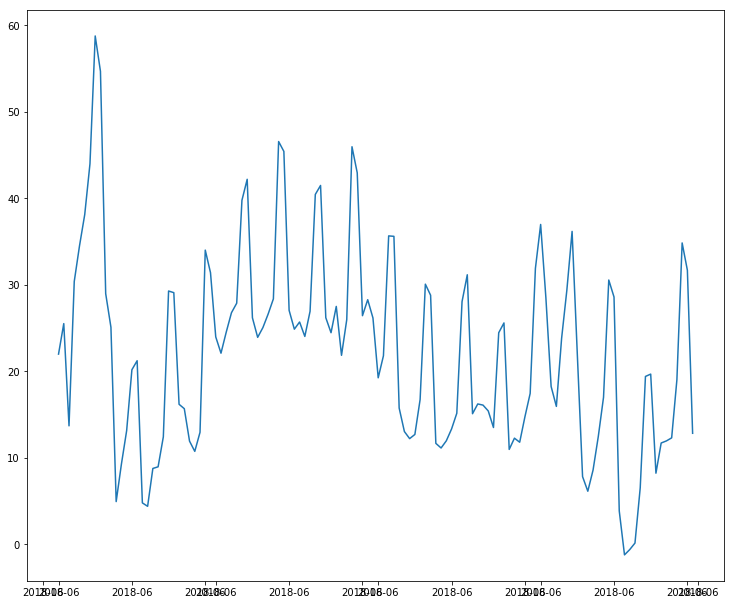

In [90]:
# SUMMER 
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 10.5, forward=True)
summer['month_year'] = summer['datetime'].dt.to_period('12M')

ax.plot(summer['datetime'],summer['price_diff'])
ax.set_xticklabels(summer['month_year'])

summer['month_year'].unique()


# fig, ax = plt.subplots()
# ax.plot(summer['datetime'],summer['price_diff'])
# ax.set_xticklabels(summer['datetime'])
# ax.set_xlabel('Date')
# ax.set_ylabel('Avg Price Difference')
# ax.set_title('Average Price Difference in Summer')

<PeriodArray>
['2018-09', '2018-10', '2018-11', '2018-12']
Length: 4, dtype: period[12M]

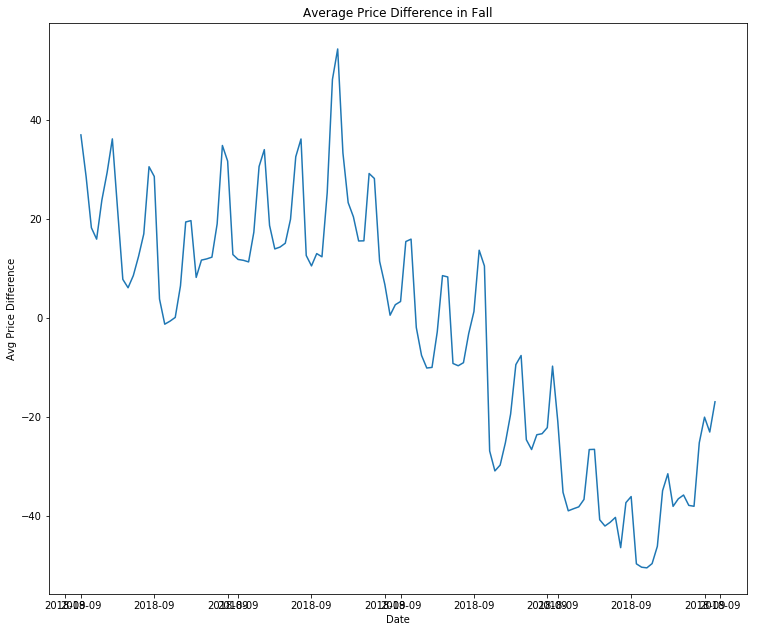

In [91]:
#FALL

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 10.5, forward=True)

ax.plot(fall['datetime'],fall['price_diff'])
ax.set_xticklabels(fall['datetime'].dt.to_period('12M'))
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Fall')
fall['month_year'].unique()


<PeriodArray>
['2018-03', '2018-04', '2018-05', '2018-06']
Length: 4, dtype: period[12M]

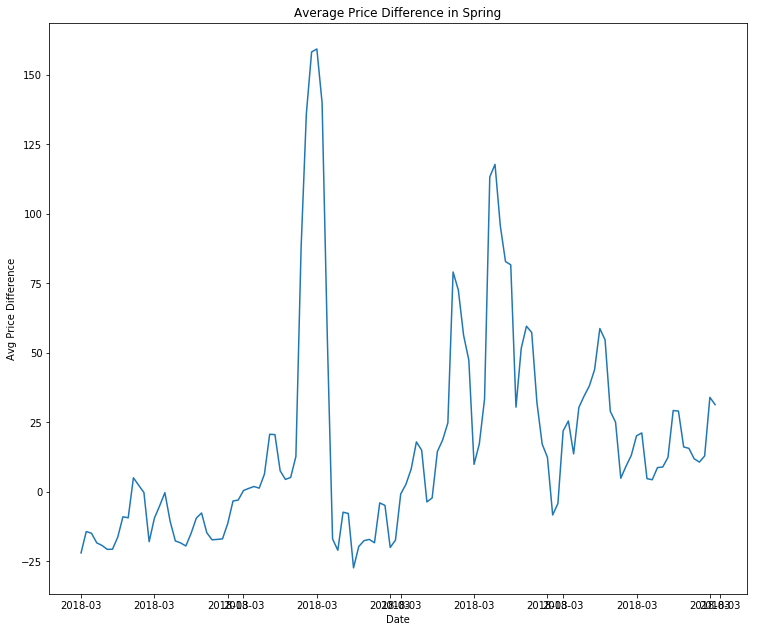

In [92]:
# SPRING

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 10.5, forward=True)

ax.plot(spring['datetime'],spring['price_diff'])
ax.set_xticklabels(spring['datetime'].dt.to_period('12M'))
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Spring')
spring['month_year'].unique()


In [93]:
data=final_sums
data['month_year'] = data['datetime'].dt.to_period('12M')
# data = data[~(data['month_year'] <= '2017-10')]  
baseData=[]
baseData=data
data.head()

,datetime,price_diff,price_x,price_y,month_year
0,2015-10-02,7.371864,36.0,36.0,2015-10
1,2015-10-03,16.953006,350.0,350.0,2015-10
2,2015-10-04,3.833924,64.0,64.0,2015-10
3,2015-10-05,-0.415049,674.0,674.0,2015-10
4,2015-10-06,0.293709,560.0,560.0,2015-10


In [94]:
data=baseData
data.head()

,datetime,price_diff,price_x,price_y,month_year
0,2015-10-02,7.371864,36.0,36.0,2015-10
1,2015-10-03,16.953006,350.0,350.0,2015-10
2,2015-10-04,3.833924,64.0,64.0,2015-10
3,2015-10-05,-0.415049,674.0,674.0,2015-10
4,2015-10-06,0.293709,560.0,560.0,2015-10


In [95]:
# final_sums.drop(columns=['maximum_nights'], inplace=True)


## KNN regression method

In [96]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [99]:
final_sums=data
data.head()

,datetime,price_diff,price_x,price_y,month_year
0,2015-10-02,7.371864,36.0,36.0,2015-10
1,2015-10-03,16.953006,350.0,350.0,2015-10
2,2015-10-04,3.833924,64.0,64.0,2015-10
3,2015-10-05,-0.415049,674.0,674.0,2015-10
4,2015-10-06,0.293709,560.0,560.0,2015-10


In [100]:
 y = final_sums['price_diff']
y

0        7.371864
1       16.953006
2        3.833924
3       -0.415049
4        0.293709
5        1.433710
6        3.003532
7       16.448026
8       16.925621
9        5.378745
10       0.445294
11      -0.554857
12       1.362756
13       6.389248
14      22.620100
15      21.040866
16      12.333424
17       8.610631
18       3.658602
19       1.957913
20       5.773305
21      12.251260
22      13.532268
23      12.890368
24       9.000800
25       8.101718
26       8.951607
27       7.751535
28       9.741176
29      10.049663
          ...    
1531    20.659862
1532    21.304113
1533    13.959169
1534    13.621723
1535    13.749606
1536    14.136479
1537    14.861442
1538    20.829870
1539    20.818173
1540    14.080723
1541    14.065939
1542    13.733688
1543    13.739700
1544    14.126865
1545    20.466588
1546    20.431820
1547    13.824021
1548    13.673412
1549    13.719391
1550    13.784704
1551    14.161633
1552    20.565045
1553    24.455541
1554    17.458952
1555    20

In [101]:
final_sums.head()
X=final_sums
X.reset_index(inplace=True)
X.head()

,index,datetime,price_diff,price_x,price_y,month_year
0,0,2015-10-02,7.371864,36.0,36.0,2015-10
1,1,2015-10-03,16.953006,350.0,350.0,2015-10
2,2,2015-10-04,3.833924,64.0,64.0,2015-10
3,3,2015-10-05,-0.415049,674.0,674.0,2015-10
4,4,2015-10-06,0.293709,560.0,560.0,2015-10


In [102]:
X['dateNumber']=0
X['year']=0
X['day']=0
for i in range (829):
    ts = pd.Timestamp(X['datetime'][i])
    X['dateNumber'][i]=ts.weekofyear  
    X['year'][i]=ts.year
    X['day'][i]=ts.dayofweek 
  

/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [103]:
X.head()

,index,datetime,price_diff,price_x,price_y,month_year,dateNumber,year,day
0,0,2015-10-02,7.371864,36.0,36.0,2015-10,40,2015,4
1,1,2015-10-03,16.953006,350.0,350.0,2015-10,40,2015,5
2,2,2015-10-04,3.833924,64.0,64.0,2015-10,40,2015,6
3,3,2015-10-05,-0.415049,674.0,674.0,2015-10,41,2015,0
4,4,2015-10-06,0.293709,560.0,560.0,2015-10,41,2015,1


In [107]:
  
# ts=[]
# ts = pd.Timestamp(X['datetime'])
# str=ts.dayofyear


# y = final_sums['price_diff']
# X = final_sums.drop(columns=['price_diff'], inplace=True)
# X = final_sums.drop(columns=['month_year'], inplace=True)
X = final_sums.drop(columns=['price_x'], inplace=True)
X.drop(columns=['index'], inplace=True)
# X.drop(columns=['level_0'], inplace=True)

X=final_sums
# X.reset_index(inplace=True)
X.head()


,datetime,price_diff,price_y,month_year,dateNumber,year,day
0,2015-10-02,7.371864,36.0,2015-10,40,2015,4
1,2015-10-03,16.953006,350.0,2015-10,40,2015,5
2,2015-10-04,3.833924,64.0,2015-10,40,2015,6
3,2015-10-05,-0.415049,674.0,2015-10,41,2015,0
4,2015-10-06,0.293709,560.0,2015-10,41,2015,1


In [108]:
X_base=[]
X_base=X
X_base.head()

,datetime,price_diff,price_y,month_year,dateNumber,year,day
0,2015-10-02,7.371864,36.0,2015-10,40,2015,4
1,2015-10-03,16.953006,350.0,2015-10,40,2015,5
2,2015-10-04,3.833924,64.0,2015-10,40,2015,6
3,2015-10-05,-0.415049,674.0,2015-10,41,2015,0
4,2015-10-06,0.293709,560.0,2015-10,41,2015,1


In [109]:
# X['day']=0
# for i in range (829):
#     ts = pd.Timestamp(X['datetime'][i])
#     X['day'][i]=ts.dayofyear  
    

X.drop(columns=['datetime'], inplace=True)
#  X.drop(columns=['year'], inplace=True)



In [116]:
# X_base.drop(columns=['index'], inplace=True)
X.drop(columns=['month_year'], inplace=True)
X.dtypes

price_diff    float64
price_y       float64
dateNumber      int64
year            int64
day             int64
dtype: object

In [112]:
y.head()

0     7.371864
1    16.953006
2     3.833924
3    -0.415049
4     0.293709
Name: price_diff, dtype: float64

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=65)  

In [119]:
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler

rmse_val=[]

for k in range(20):
    k = k+1
#     sc = StandardScaler()  
#     X_train = sc.fit_transform(X_train)  
#     X_test = sc.transform(X_test)
    regressor = KNeighborsRegressor(n_neighbors = k) 
    regressor.fit(X_train, y_train)
    pred_test = regressor.predict(X_test)
    error = sqrt(mean_squared_error(y_test,pred_test))
    rmse_val.append(error) 
#     print('RMSE value for k= ' , k , 'is:', error)
    mape_train = np.mean(np.abs((y_train - y_train) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - pred_test) / y_test)) * 100
    #print('Mape_train value for k= ' , k , 'is:', mape_train)
    print('k= ' , k ,'Mape_test :', mape_test,'RMSE:', error )
    

k=  1 Mape_test : 96.93027902130311 RMSE: 7.590691475391578
k=  2 Mape_test : 86.09641301850976 RMSE: 7.498314148695556
k=  3 Mape_test : 92.06520064556254 RMSE: 7.47900908478427
k=  4 Mape_test : 116.1965083858999 RMSE: 8.021621987432491
k=  5 Mape_test : 137.5296161991317 RMSE: 8.636909094103114
k=  6 Mape_test : 156.08911059579245 RMSE: 8.89088812574991
k=  7 Mape_test : 150.4555398344755 RMSE: 9.375949380971681
k=  8 Mape_test : 158.35140946045752 RMSE: 9.69285460041786
k=  9 Mape_test : 176.7396321598467 RMSE: 9.964856560060792
k=  10 Mape_test : 193.08006832075503 RMSE: 10.095211442341665
k=  11 Mape_test : 193.11627468688204 RMSE: 10.325921003334656
k=  12 Mape_test : 218.18381413608395 RMSE: 10.451439009253889
k=  13 Mape_test : 208.76669456594024 RMSE: 10.715007911712435
k=  14 Mape_test : 199.8977371169692 RMSE: 10.892006517151101
k=  15 Mape_test : 191.96289640959222 RMSE: 11.119016723559437
k=  16 Mape_test : 188.33967487978495 RMSE: 11.324549256956765
k=  17 Mape_test : 18

## Random Forest Regres

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 

def random_forest(model, X_train, X_test, Y_train, Y_test):
#     sc = StandardScaler()  
#     X_train = sc.fit_transform(X_train)  
#     X_test = sc.transform(X_test)
    model.fit(X_train, y_train)  
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    return mape_train, y_pred_test, mape_test, mse_test, rmse_test, model
def modelling(model, X_train, X_test, y_train, y_test):
#     sc = StandardScaler()  
#     X_train = sc.fit_transform(X_train)  
#     X_test = sc.transform(X_test)
    model.fit(X_train, y_train)  
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    return [mape_train, mape_test,mae_train, mae_test, mse_test, rmse_test,y_pred_test]    

In [121]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()  
print(regressor)
mape_train, y_pred_test, mape_test, mse_test, rmse_test, model = random_forest(regressor,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', mape_train,'\nMAPE for test is: ', mape_test,'\nMSE for test is: ', mse_test, '\nRMSE for test is: ', rmse_test)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAPE for train is:  0.43080157287637827 
MAPE for test is:  2.2249294924691134 
MSE for test is:  0.8272574108042962 
RMSE for test is:  0.9095369210781364


/anaconda2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [122]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X)
X_feat = data.values
Y_feat = y.values
print(kf) 


KFold(n_splits=5, random_state=None, shuffle=False)


In [135]:

for n in range(2,8):
    kf = KFold(n_splits=n)
    kf.get_n_splits(X)
    X_feat = data.values
    Y_feat = y.values

    max_depth_list = [1,3,4,5,6,7,8,10,11,20]
    for depth in max_depth_list:
        MAPE_TEST = []  
        MAPE_TRAIN =[]
        regressor = RandomForestRegressor(n_estimators=10, max_depth= depth, criterion="mae") 

        for i, j in kf.split(data):
            X_train, X_test = X_feat[i], X_feat[j]
            y_train, y_test = Y_feat[i], Y_feat[j]
            mape_train, mape_test,mae_train, mae_test, mse_test, rmse_test,y_pred_test = modelling(regressor,X_train, X_test, y_train, y_test)
    #         print("depth = ",depth,"MAPE = ", mape_test,"MAE = ",mape_train)
            MAPE_TEST.append(mape_test)
            MAPE_TRAIN.append(mape_train)
            if(mape_test<0.7):
                print("KF = ",n," Depth = ",depth,"MAPE = ",(mape_test),"\t MAE = ",(mae_test),"\t RMSE = ", (rmse_test))
    #         if(mae_test<15):
    #             print("depth = ",depth,"MAPE = ", mape_test,"MAE = ",mape_train)

    #print("depth = ",depth, MAPE_TEST)

KF =  5  Depth =  10 MAPE =  0.6104744727927983 	 MAE =  0.13330057510468044 	 RMSE =  0.467667138863785
KF =  5  Depth =  20 MAPE =  0.669235855440288 	 MAE =  0.11133241377316015 	 RMSE =  0.32612065252614
KF =  6  Depth =  8 MAPE =  0.6070256888863003 	 MAE =  0.108229876950102 	 RMSE =  0.1554604899945894
KF =  6  Depth =  10 MAPE =  0.4341119205299237 	 MAE =  0.07879860218218392 	 RMSE =  0.11962605547602789
KF =  6  Depth =  11 MAPE =  0.5542158090902378 	 MAE =  0.07153513335726727 	 RMSE =  0.16828716664380483
KF =  6  Depth =  11 MAPE =  0.4297394308205573 	 MAE =  0.07991873266269002 	 RMSE =  0.13163301213207243
KF =  6  Depth =  20 MAPE =  0.6827874075625333 	 MAE =  0.07346238570592736 	 RMSE =  0.20200758990981915
KF =  6  Depth =  20 MAPE =  0.39535172102626487 	 MAE =  0.07440325064032262 	 RMSE =  0.11930685304527178
KF =  7  Depth =  8 MAPE =  0.6259263857523961 	 MAE =  0.1033723103838196 	 RMSE =  0.14955562560879512
KF =  7  Depth =  10 MAPE =  0.6568474202102275 

In [138]:
kf = KFold(n_splits=7)
kf.get_n_splits(X)
X_feat = data.values
Y_feat = y.values

max_depth_list = [10,12,14,18,20,25,27]
for depth in max_depth_list:
    MAPE_TEST = []  
    MAPE_TRAIN =[]
    regressor = RandomForestRegressor(n_estimators=10, max_depth= depth, criterion="mae") 

    for i, j in kf.split(data):
        X_train, X_test = X_feat[i], X_feat[j]
        y_train, y_test = Y_feat[i], Y_feat[j]
        mape_train, mape_test,mae_train, mae_test, mse_test, rmse_test,y_pred_test = modelling(regressor,X_train, X_test, y_train, y_test)
    #         print("depth = ",depth,"MAPE = ", mape_test,"MAE = ",mape_train)
        MAPE_TEST.append(mape_test)
        MAPE_TRAIN.append(mape_train)
        if(mape_test< 0.4 ):
            print("KF = ",n," Depth = ",depth,"MAPE = ",(mape_test),"\t MAE = ",(mae_test),"\t RMSE = ", (rmse_test))
    #         if(mae_test<15):
    #             print("depth = ",depth,"MAPE = ", mape_test,"MAE = ",mape_train)

    #print("depth = ",depth, MAPE_TEST)

KF =  7  Depth =  12 MAPE =  0.3668483736736592 	 MAE =  0.06861103222401096 	 RMSE =  0.11151867347726123
KF =  7  Depth =  18 MAPE =  0.3805324509401731 	 MAE =  0.0666527457817055 	 RMSE =  0.11433757216798356
KF =  7  Depth =  27 MAPE =  0.393132694704924 	 MAE =  0.06932680531890953 	 RMSE =  0.1126063761666706


## Result:
KF =  7  Depth =  18 MAPE =  0.3805324509401731 	 MAE =  0.0666527457817055 	 RMSE =  0.11433757216798356


In [140]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf) 

n_estimator_list = [10,15,20,25,30,50,60]
for est in n_estimator_list:
    MAPE_TEST = []  
    MAPE_TRAIN =[]
    mat=[]
    regressor = RandomForestRegressor(max_depth= 20,n_estimators = est) 

    for i, j in kf.split(X_feat):
        X_train, X_test = X_feat[i], X_feat[j]
        y_train, y_test = Y_feat[i], Y_feat[j]
        result = modelling(regressor,X_train, X_test, y_train, y_test)
    MAPE_TEST.append(result[1])
    MAPE_TRAIN.append(result[0])
    
    print("estimator = ",est, MAPE_TEST)
    

KFold(n_splits=5, random_state=None, shuffle=False)
estimator =  10 [0.7899651598613154]
estimator =  15 [0.5530450825306901]
estimator =  20 [0.4928781271913986]
estimator =  25 [0.5225845646287692]
estimator =  30 [0.5109734612139841]
estimator =  50 [0.39567302308267166]
estimator =  60 [0.4506783409415665]


## Grid-search for Random Forest Regressor to find the best parameters

In [141]:
from sklearn.model_selection import GridSearchCV
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf) 
regressor = RandomForestRegressor() 
param_grid = {"n_estimators": [20,25,30,40,200],
              "criterion":['mse','mae'],
              "max_features": ['auto', 'sqrt', 'log2'],
             "max_depth": [1,5,10,15]}

grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

print(grid_search.score)

KFold(n_splits=5, random_state=None, shuffle=False)
<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 25, 30, 40, 200], 'criterion': ['mse', 'mae'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [1, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)>


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [142]:
grid_search.best_params_


{'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'auto',
 'n_estimators': 30}

In [143]:
grid_search.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 25, 30, 40, 200], 'criterion': ['mse', 'mae'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [1, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)>

In [154]:


for n in range(2,8):
    kf = KFold(n_splits=n)
    kf.get_n_splits(X)
    X_feat = data.values
    Y_feat = y.values

    max_depth_list = [1,7,8,10,20,25]
    for depth in max_depth_list:
        MAPE_TEST = []  
        MAPE_TRAIN =[]
        regressor = RandomForestRegressor(criterion= 'mse', max_depth= 15, max_features= 'auto', n_estimators= 40) 

        for i, j in kf.split(data):
            X_train, X_test = X_feat[i], X_feat[j]
            y_train, y_test = Y_feat[i], Y_feat[j]
            mape_train, mape_test,mae_train, mae_test, mse_test, rmse_test,y_pred_test = modelling(regressor,X_train, X_test, y_train, y_test)
    #         print("depth = ",depth,"MAPE = ", mape_test,"MAE = ",mape_train)
            MAPE_TEST.append(mape_test)
            MAPE_TRAIN.append(mape_train)
            if(mape_test<0.3 ):
                print("KF = ",n," Depth = ",depth,"MAPE = ",(mape_test),"\t MAE = ",(mae_test),"\t RMSE = ",(rmse_test))



KF =  7  Depth =  25 MAPE =  0.2980672311139231 	 MAE =  0.0532345574356782 	 RMSE =  0.0802431751118691


In [155]:
rfModel= RandomForestRegressor(criterion= 'mse', max_depth= 15, max_features= 'auto', n_estimators= 40)

## Using Decision Tree Regressor

In [145]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
model1 =DecisionTreeRegressor()
print(model1)
metrices_list = modelling(model1,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', str(metrices_list[0]),',MAPE for test is: ', str(metrices_list[1]),
      ',MAE for train is: ', str(metrices_list[2]),',MAE for test is: ', str(metrices_list[3]), 
      ',MSE for test is: ', str(metrices_list[4]),',RMSE for test is: ',str(metrices_list[5]))


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
MAPE for train is:  9.523276730122006e-05 ,MAPE for test is:  0.46005900853482784 ,MAE for train is:  3.406427841068023e-06 ,MAE for test is:  0.07896415646489877 ,MSE for test is:  0.016187843664365383 ,RMSE for test is:  0.12723145705510638


### Using grid-search to find the best parameters


In [162]:
def bestParameters():
        #regressor = tree.DecisionTreeRegressor() 

        # Set the parameters by cross-validation
        tuned_parameters = [{'max_features': ['sqrt', 'log2', None],
                             'max_depth': range(11,20,60),
                             }
                            ]


        reg = GridSearchCV(DecisionTreeRegressor(), tuned_parameters, cv=5)
        reg.fit(X_train, y_train)

        print ("Best parameters set found on development set:\n")
        print (reg.best_params_)

        
bestParameters()

Best parameters set found on development set:

{'max_depth': 11, 'max_features': None}


### Using best parameters to calculate the mape using Decision Tree Regressor

In [164]:
decisionTreeModel = DecisionTreeRegressor(max_features=None, max_depth = 40)
print(model2)
metrices_list = modelling(model2,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', str(metrices_list[0]),',MAPE for test is: ', str(metrices_list[1]),
      ',MAE for train is: ', str(metrices_list[2]),',MAE for test is: ', str(metrices_list[3]), 
      ',MSE for test is: ', str(metrices_list[4]),',RMSE for test is: ',str(metrices_list[5]))


DecisionTreeRegressor(criterion='mse', max_depth=40, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
MAPE for train is:  9.523276730122006e-05 ,MAPE for test is:  0.4871301835573235 ,MAE for train is:  3.406427841068023e-06 ,MAE for test is:  0.07878875689620728 ,MSE for test is:  0.01388963720337953 ,RMSE for test is:  0.11785430498449995


## KNN Neighbors

In [165]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor() 
print(regressor)
metrices = modelling(regressor,X_train, X_test, y_train, y_test)
print('MAPE for train is: ', str(metrices[0]),',MAPE for test is: ', str(metrices[1]),
      ',MAE for train is: ', str(metrices[2]),',MAE for test is: ', str(metrices[3]), 
      ',MSE for test is: ', str(metrices[4]),',RMSE for test is: ',str(metrices[5]))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')
MAPE for train is:  79.28973062860648 ,MAPE for test is:  25.559440895594186 ,MAE for train is:  3.2740237454092496 ,MAE for test is:  2.7832927692091762 ,MSE for test is:  19.410728099252577 ,RMSE for test is:  4.405760785523038



## Pickling the final model

In [166]:
import pickle
ran_for = open('RFModelSurge.pkl', 'wb')
pickle.dump(rfModel, ran_for)
print(ran_for)
ran_for.close()

decision_tree = open('DTModelSurge.pkl', 'wb')
pickle.dump(decisionTreeModel, decision_tree)
print(decision_tree)
decision_tree.close()


<_io.BufferedWriter name='RFModelSurge.pkl'>
<_io.BufferedWriter name='DTModelSurge.pkl'>


## Scores

 Random Forest:
        KF = 7 Depth = 18 MAPE = 0.38 MAE = 0.066 RMSE = 0.114

Decision Tree:
                MAPE=0.460  MAE= 0.078    RMSE= 0.127

KNN
    MAPE =25.55  MAE =  2.78